In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

sys.path.append('/explore/nobackup/people/jacaraba/development/satvision-pix4d')

from satvision_pix4d.configs.config import _C, _update_config_from_file
from satvision_pix4d.pipelines import PIPELINES, get_available_pipelines
from satvision_pix4d.datasets.abi_temporal_benchmark_dataset import ABITemporalBenchmarkDataset
from satvision_pix4d.datasets.abi_temporal_dataset import ABITemporalDataset

[2025-08-06 13:53:49,321] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-08-06 13:53:51,764] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [2]:
# Whether to save files to a PDF, and where to save them 
save_to_pdf = False
pdf_path = "chip_plot.pdf"

# RGB indices for ABI data (16 channels instead of 14)
rgb_index = [0, 2, 1]  # Adjust based on your ABI channels

# Use your local model paths instead of downloading
model_filename = '/explore/nobackup/projects/pix4dcloud/jacaraba/model_development/satmae/' + \
    'satmae_satvision_pix4d_pretrain-dev/satmae_satvision_pix4d_pretrain-dev/best-epoch=373-val_loss=36.2750.ckpt/checkpoint/mp_rank_00_model_states.pt'

config_filename = '/explore/nobackup/people/jacaraba/development/satvision-pix4d/tests/configs/test_satmae_dev.yaml'

In [3]:
# Load configuration
config = _C.clone()
_update_config_from_file(config, config_filename)
print("Loaded configuration file.")

# Update config with your paths
config.defrost()
config.MODEL.PRETRAINED = model_filename
config.DATA.DATA_PATHS = ['/explore/nobackup/people/jacaraba/projects/SatVision-Pix4d/tiles_pix4d/']
config.OUTPUT = '.'
config.freeze()
print("Updated configuration file.")

# Get pipeline and load model
available_pipelines = get_available_pipelines()
print("Available pipelines:", available_pipelines)

pipeline = PIPELINES[config.PIPELINE]
print(f'Using {pipeline}')

ptlPipeline = pipeline(config)

# Load model
print(f'Attempting to load checkpoint from {config.MODEL.PRETRAINED}')
model = ptlPipeline.load_checkpoint(config.MODEL.PRETRAINED, config)
print('Successfully applied checkpoint')

model.cpu()
model.eval()
print('Successfully moved to CPU and eval mode')

Loaded configuration file.
Updated configuration file.
Available pipelines: {'satvision_pix4d_satmae_pretrain': <class 'satvision_pix4d.pipelines.satvision_pix4d_pretrain.SatVisionPix4DSatMAEPretrain'>}
Using <class 'satvision_pix4d.pipelines.satvision_pix4d_pretrain.SatVisionPix4DSatMAEPretrain'>
Attempting to load checkpoint from /explore/nobackup/projects/pix4dcloud/jacaraba/model_development/satmae/satmae_satvision_pix4d_pretrain-dev/satmae_satvision_pix4d_pretrain-dev/best-epoch=373-val_loss=36.2750.ckpt/checkpoint/mp_rank_00_model_states.pt
Successfully applied checkpoint
Successfully moved to CPU and eval mode


In [4]:
import os
import random

data_dir = '/explore/nobackup/people/jacaraba/projects/SatVision-Pix4d/tiles_pix4d/'

all_zarr_files = [f for f in os.listdir(data_dir) if f.endswith('.zarr')]
print(f"Found {len(all_zarr_files)} zarr files in directory")

train_ds = ABITemporalDataset(
    data_paths=[data_dir], 
    img_size=512,
    in_chans=16,
    data_var='Rad'
)

print(f"Dataset contains {len(train_ds)} samples from all files")

# Process multiple samples from the dataset
num_samples = min(5, len(train_ds))  
print(f"Processing {num_samples} samples from multiple files...")

all_inputs = []
all_outputs = []
all_masks = []
all_losses = []

print(f"\nProcessing samples for reconstruction...")
for sample_idx in tqdm(range(num_samples)):
    try:
        imgs, ts = train_ds[sample_idx]
        
        # NO NORMALIZATION
        imgs_batch = imgs.unsqueeze(0).cpu()
        if isinstance(ts, np.ndarray):
            ts = torch.from_numpy(ts).float()
        ts_batch = ts.unsqueeze(0).cpu()
        
        with torch.no_grad():
            loss, pred, mask = model(imgs_batch, ts_batch)
            
            B, T, C, H, W = imgs_batch.shape
            pred_imgs = model.model.unpatchify(pred, T, H, W)
            pred_imgs = torch.clamp(pred_imgs, 0, 1)
        
        # Store results
        all_inputs.append(imgs_batch.cpu().squeeze(0))
        all_outputs.append(pred_imgs.cpu().squeeze(0))
        all_masks.append(mask.cpu().squeeze(0))
        all_losses.append(loss.cpu().item())
        
        if sample_idx % 10 == 0:  # Print progress every 10 samples
            print(f"Sample {sample_idx}: Loss = {loss.item():.2f}")
        
    except Exception as e:
        print(f"Error processing sample {sample_idx}: {e}")
        continue

print(f"\n=== FINAL RESULTS ===")
print(f"Total samples processed: {len(all_inputs)}")
print(f"Average loss across all samples: {np.mean(all_losses):.4f}")

# Update global variables for compatibility with existing code
inputs = all_inputs
outputs = all_outputs
masks = all_masks
losses = all_losses

Found 889 zarr files in directory
Dataset contains 889 samples from all files
Processing 5 samples from multiple files...

Processing samples for reconstruction...


 20%|██        | 1/5 [00:13<00:52, 13.22s/it]

Sample 0: Loss = 0.02


100%|██████████| 5/5 [01:04<00:00, 12.81s/it]


=== FINAL RESULTS ===
Total samples processed: 5
Average loss across all samples: 0.0253


In [5]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Step 1: Define metric calculation functions

def calculate_mse(original, reconstructed):
    """Calculate Mean Squared Error between original and reconstructed images"""
    return torch.mean((original - reconstructed) ** 2).item()

def calculate_psnr(mse, data_range=1.0):
    """Calculate Peak Signal-to-Noise Ratio from MSE"""
    if mse == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse))

def calculate_mae(original, reconstructed):
    """Calculate Mean Absolute Error between original and reconstructed images"""
    return torch.mean(torch.abs(original - reconstructed)).item()

def calculate_ssim_fast(original, reconstructed, sample_channels=4):
    """
    Fast SSIM calculation - only sample a few channels to speed up computation
    SSIM is expensive to compute, so we sample representative channels
    """
    if isinstance(original, torch.Tensor):
        original = original.numpy()
    if isinstance(reconstructed, torch.Tensor):
        reconstructed = reconstructed.numpy()
    
    ssim_scores = []
    
    # Sample channels across time and spectral dimensions
    total_channels = original.shape[0] * original.shape[1]  # T * C
    channel_indices = np.linspace(0, total_channels-1, sample_channels, dtype=int)
    
    for idx in channel_indices:
        t_idx = idx // original.shape[1]  # timestep
        c_idx = idx % original.shape[1]   # channel
        
        if t_idx < original.shape[0] and c_idx < original.shape[1]:
            try:
                score = ssim(original[t_idx, c_idx], reconstructed[t_idx, c_idx], 
                           data_range=1.0)
                ssim_scores.append(score)
            except:
                continue
    
    return np.mean(ssim_scores) if ssim_scores else 0.0

# Step 2: Set up batch processing for large dataset
print("Calculating comprehensive metrics for large dataset...")
print(f"Processing {len(inputs)} samples...")
print("="*70)

metrics_results = []
batch_size = 20  # Process in manageable chunks to avoid memory issues

# Step 3: Process data in batches to handle large datasets efficiently
for batch_start in range(0, len(inputs), batch_size):
    batch_end = min(batch_start + batch_size, len(inputs))
    batch_indices = range(batch_start, batch_end)
    
    print(f"Processing batch {batch_start//batch_size + 1}/{(len(inputs)-1)//batch_size + 1} "
          f"(samples {batch_start}-{batch_end-1})")
    
    batch_metrics = []
    
    # Calculate metrics for each sample in the current batch
    for i in batch_indices:
        original = inputs[i]
        reconstructed = outputs[i]
        
        # Calculate basic reconstruction metrics
        mse = calculate_mse(original, reconstructed)
        mae = calculate_mae(original, reconstructed)
        psnr = calculate_psnr(mse)
        
        # Calculate structural similarity (expensive, so we sample channels)
        ssim_score = calculate_ssim_fast(original, reconstructed, sample_channels=4)
        
        # Step 3a: Calculate RGB-specific metrics for visual interpretation
        rgb_indices = [1, 0, 2]  # Map to red, green, blue bands
        rgb_metrics = {}
        
        for band_name, band_idx in zip(['red', 'green', 'blue'], rgb_indices):
            if band_idx < original.shape[1]:
                # Average across time dimension for each RGB band
                orig_band = original[:, band_idx, :, :].mean(dim=0)
                recon_band = reconstructed[:, band_idx, :, :].mean(dim=0)
                
                band_mse = calculate_mse(orig_band, recon_band)
                band_psnr = calculate_psnr(band_mse)
                
                rgb_metrics[band_name] = {'mse': band_mse, 'psnr': band_psnr}
        
        # Store all metrics for this sample
        sample_metrics = {
            'sample_idx': i,
            'loss': losses[i],
            'mse': mse,
            'mae': mae,
            'psnr': psnr,
            'ssim': ssim_score,
            'rgb_metrics': rgb_metrics
        }
        
        batch_metrics.append(sample_metrics)
    
    metrics_results.extend(batch_metrics)
    
    # Print progress for this batch
    batch_mse = [m['mse'] for m in batch_metrics]
    batch_psnr = [m['psnr'] for m in batch_metrics]
    print(f"  Batch avg MSE: {np.mean(batch_mse):.6f}, avg PSNR: {np.mean(batch_psnr):.2f}")

# Step 4: Calculate overall dataset statistics
print("\n" + "="*70)
print("LARGE DATASET METRICS SUMMARY")
print("="*70)

# Extract all metric values for statistical analysis
all_mse = [m['mse'] for m in metrics_results]
all_mae = [m['mae'] for m in metrics_results]
all_psnr = [m['psnr'] for m in metrics_results]
all_ssim = [m['ssim'] for m in metrics_results]
all_loss = [m['loss'] for m in metrics_results]

print(f"Dataset Statistics (n={len(metrics_results)} samples):")
print(f"  MSE:  {np.mean(all_mse):.6f} ± {np.std(all_mse):.6f}")
print(f"  MAE:  {np.mean(all_mae):.6f} ± {np.std(all_mae):.6f}")
print(f"  PSNR: {np.mean(all_psnr):.2f} ± {np.std(all_psnr):.2f} dB")
print(f"  SSIM: {np.mean(all_ssim):.4f} ± {np.std(all_ssim):.4f}")
print(f"  Loss: {np.mean(all_loss):.2f} ± {np.std(all_loss):.2f}")

# Step 5: Analyze performance distribution across the dataset
print(f"\nPerformance Distribution Analysis:")
percentiles = [10, 25, 50, 75, 90]
mse_percentiles = np.percentile(all_mse, percentiles)
psnr_percentiles = np.percentile(all_psnr, percentiles)

print(f"MSE Percentiles:")
for p, val in zip(percentiles, mse_percentiles):
    print(f"  {p}th: {val:.6f}")

print(f"PSNR Percentiles:")
for p, val in zip(percentiles, psnr_percentiles):
    print(f"  {p}th: {val:.2f} dB")

# Step 6: Categorize samples by reconstruction quality
mse_threshold_good = np.percentile(all_mse, 33)  # Bottom third (best reconstructions)
mse_threshold_bad = np.percentile(all_mse, 67)   # Top third (worst reconstructions)

good_samples = [i for i, m in enumerate(all_mse) if m <= mse_threshold_good]
medium_samples = [i for i, m in enumerate(all_mse) if mse_threshold_good < m <= mse_threshold_bad]
bad_samples = [i for i, m in enumerate(all_mse) if m > mse_threshold_bad]

print(f"\nPerformance Categories:")
print(f"  Good samples (bottom 33%): {len(good_samples)} samples")
print(f"    Avg MSE: {np.mean([all_mse[i] for i in good_samples]):.6f}")
print(f"    Avg PSNR: {np.mean([all_psnr[i] for i in good_samples]):.2f} dB")

print(f"  Medium samples (middle 33%): {len(medium_samples)} samples")
print(f"    Avg MSE: {np.mean([all_mse[i] for i in medium_samples]):.6f}")
print(f"    Avg PSNR: {np.mean([all_psnr[i] for i in medium_samples]):.2f} dB")

print(f"  Bad samples (top 33%): {len(bad_samples)} samples")
print(f"    Avg MSE: {np.mean([all_mse[i] for i in bad_samples]):.6f}")
print(f"    Avg PSNR: {np.mean([all_psnr[i] for i in bad_samples]):.2f} dB")

# Step 7: Analyze RGB band performance for visual assessment
print(f"\nRGB Band Performance Summary:")
for band_name in ['red', 'green', 'blue']:
    band_mse = [m['rgb_metrics'][band_name]['mse'] for m in metrics_results 
                if band_name in m['rgb_metrics']]
    band_psnr = [m['rgb_metrics'][band_name]['psnr'] for m in metrics_results 
                 if band_name in m['rgb_metrics']]
    
    if band_mse:
        print(f"  {band_name.capitalize()}: MSE={np.mean(band_mse):.6f}, PSNR={np.mean(band_psnr):.2f}dB")

# Step 8: Identify best and worst performing samples
best_idx = np.argmin(all_mse)
worst_idx = np.argmax(all_mse)

print(f"\nExtreme Samples:")
print(f"  Best sample #{best_idx}: MSE={all_mse[best_idx]:.6f}, PSNR={all_psnr[best_idx]:.2f}dB")
print(f"  Worst sample #{worst_idx}: MSE={all_mse[worst_idx]:.6f}, PSNR={all_psnr[worst_idx]:.2f}dB")
print(f"  Performance range: {all_mse[worst_idx]/all_mse[best_idx]:.1f}x difference")

# Step 9: Save results for further analysis
performance_categories = {
    'good': good_samples,
    'medium': medium_samples, 
    'bad': bad_samples
}

print(f"\nMetrics calculation complete!")
print(f"Results stored in 'metrics_results' and 'performance_categories' variables")

Calculating comprehensive metrics for large dataset...
Processing 5 samples...
Processing batch 1/1 (samples 0-4)
  Batch avg MSE: 0.078641, avg PSNR: 11.05

LARGE DATASET METRICS SUMMARY
Dataset Statistics (n=5 samples):
  MSE:  0.078641 ± 0.002900
  MAE:  0.129576 ± 0.003396
  PSNR: 11.05 ± 0.16 dB
  SSIM: 0.0992 ± 0.0199
  Loss: 0.03 ± 0.01

Performance Distribution Analysis:
MSE Percentiles:
  10th: 0.075156
  25th: 0.077779
  50th: 0.079927
  75th: 0.080454
  90th: 0.081163
PSNR Percentiles:
  10th: 10.91 dB
  25th: 10.94 dB
  50th: 10.97 dB
  75th: 11.09 dB
  90th: 11.24 dB

Performance Categories:
  Good samples (bottom 33%): 2 samples
    Avg MSE: 0.075593
    Avg PSNR: 11.22 dB
  Medium samples (middle 33%): 1 samples
    Avg MSE: 0.079927
    Avg PSNR: 10.97 dB
  Bad samples (top 33%): 2 samples
    Avg MSE: 0.081045
    Avg PSNR: 10.91 dB

RGB Band Performance Summary:
  Red: MSE=0.065450, PSNR=12.04dB
  Green: MSE=0.062425, PSNR=12.41dB
  Blue: MSE=0.178824, PSNR=7.66dB

Ex

ABI Satellite Data Reconstruction Results:
Inputs shape: torch.Size([6, 16, 512, 512])
Outputs shape: torch.Size([1, 6, 16, 512, 512])
Data shapes - Original: torch.Size([16, 512, 512]), Reconstructed: torch.Size([16, 512, 512])
Data ranges - Original: [0.000, 1.000], Reconstructed: [0.000, 1.000]


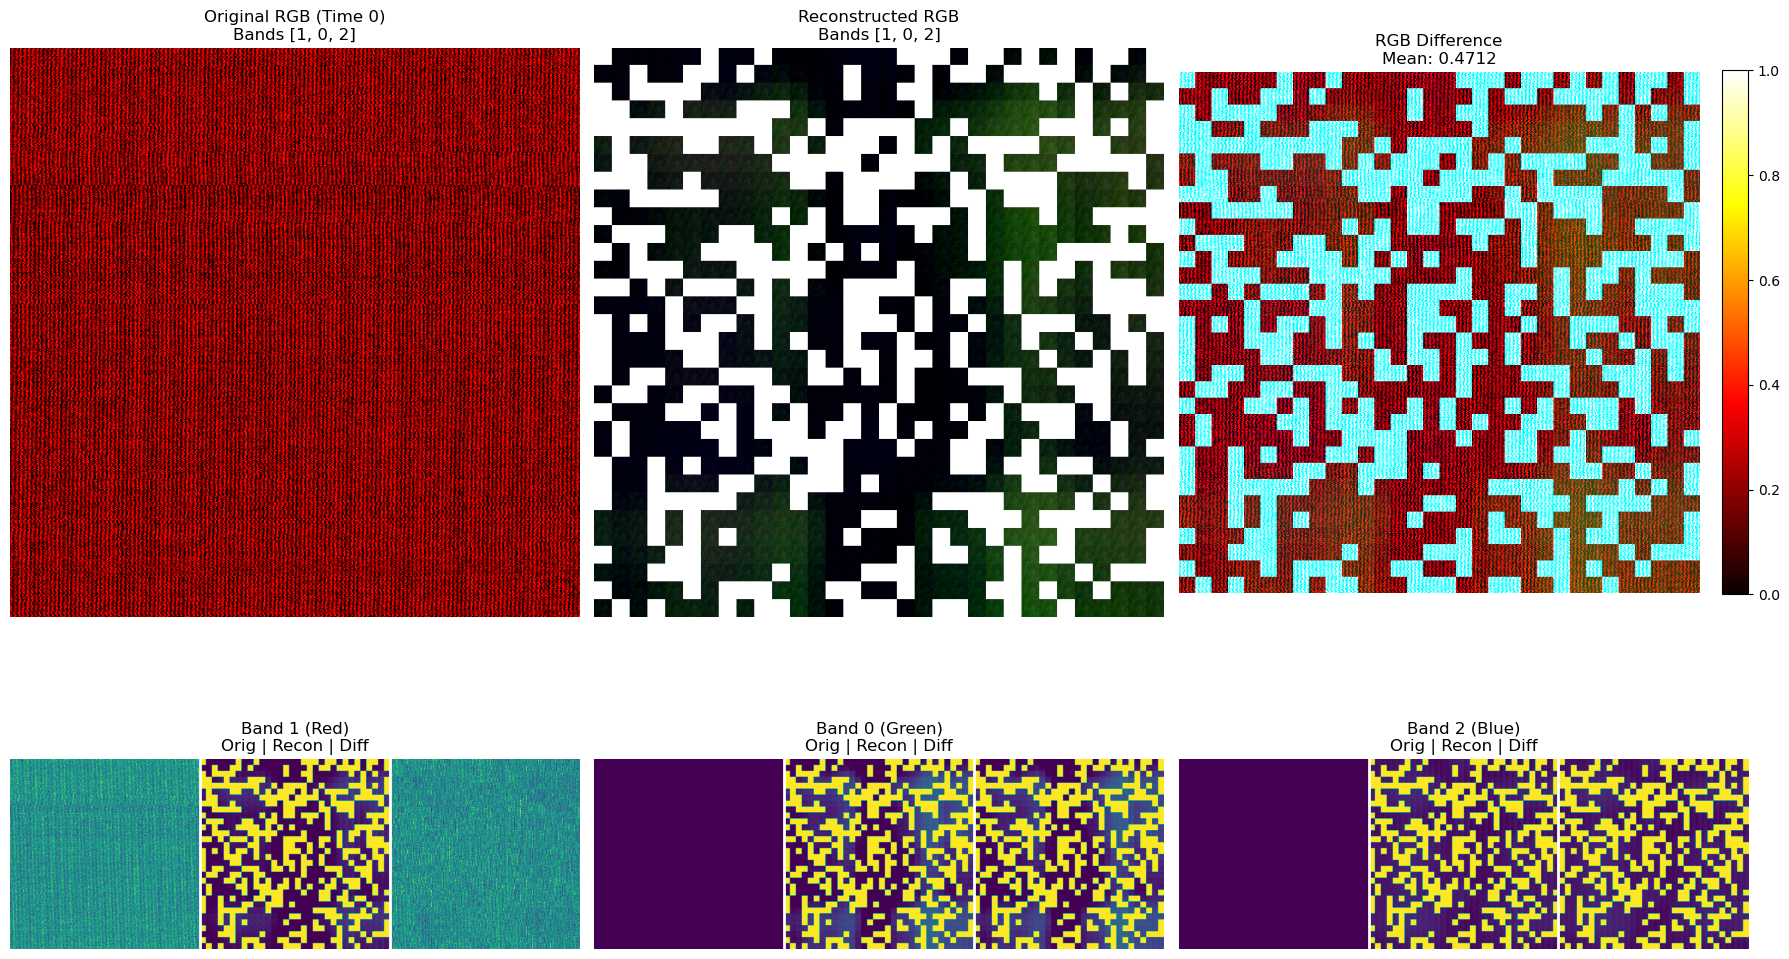


Quantitative Metrics:
  Overall MSE (all bands): 0.083215
  RGB MSE: 0.404492
  RGB Mean Abs Diff: 0.4712
  RGB Max Abs Diff: 1.0000
  Pixels with >10% difference: 63.0%


In [6]:
def visualize_reconstruction(inputs, outputs, sample_idx=0, timestep=0, rgb_index=[1, 0, 2]):
    """Visualize original vs reconstructed for ABI satellite data"""
    
    # Step 1: Convert inputs and outputs to proper tensor format
    if isinstance(inputs, list):
        if len(inputs) > 0:
            inputs_tensor = inputs[0] if torch.is_tensor(inputs[0]) else torch.tensor(inputs[0])
        else:
            print("No input data available")
            return
    else:
        inputs_tensor = inputs
    
    if isinstance(outputs, list):
        if len(outputs) > 0:
            outputs_tensor = outputs[0] if torch.is_tensor(outputs[0]) else torch.tensor(outputs[0])
        else:
            print("No output data available")
            return
    else:
        outputs_tensor = outputs
    
    print(f"Inputs shape: {inputs_tensor.shape}")
    print(f"Outputs shape: {outputs_tensor.shape}")
    
    # Step 2: Handle different tensor shapes to extract the right data slice
    if len(inputs_tensor.shape) == 4:  # [time, channels, height, width]
        # Get all channels for a specific time
        original = inputs_tensor[timestep]  # [16, 512, 512]
    elif len(inputs_tensor.shape) == 5:  # [batch, time, channels, height, width]
        original = inputs_tensor[sample_idx, timestep]  # [16, 512, 512]
    else:
        print(f"Unexpected input shape: {inputs_tensor.shape}")
        return
    
    if len(outputs_tensor.shape) == 4:  # [time, channels, height, width]
        reconstructed = outputs_tensor[timestep]  # [16, 512, 512]
    elif len(outputs_tensor.shape) == 5:  # [batch, time, channels, height, width]
        reconstructed = outputs_tensor[sample_idx, timestep]  # [16, 512, 512]
    else:
        print(f"Unexpected output shape: {outputs_tensor.shape}")
        return
    
    print(f"Data shapes - Original: {original.shape}, Reconstructed: {reconstructed.shape}")
    print(f"Data ranges - Original: [{original.min():.3f}, {original.max():.3f}], "
          f"Reconstructed: [{reconstructed.min():.3f}, {reconstructed.max():.3f}]")
    
    # Step 3: Move tensors to CPU and prepare for visualization
    original = original.detach().cpu()
    reconstructed = reconstructed.detach().cpu()
    
    # Create RGB images using specified satellite bands
    original_rgb = original[rgb_index].permute(1, 2, 0).numpy()  # (512, 512, 3)
    reconstructed_rgb = reconstructed[rgb_index].permute(1, 2, 0).numpy()  # (512, 512, 3)
    
    # Step 4: Define normalization function for satellite data
    def normalize_abi_rgb(rgb_data):
        """Normalize ABI RGB data for better visualization using percentile scaling"""
        normalized = np.zeros_like(rgb_data)
        for i in range(3):
            channel = rgb_data[:, :, i]
            # Use 2nd and 98th percentiles to avoid outliers
            p2, p98 = np.percentile(channel, [2, 98])
            if p98 > p2:
                normalized[:, :, i] = np.clip((channel - p2) / (p98 - p2), 0, 1)
            else:
                normalized[:, :, i] = 0
        return normalized
    
    # Step 5: Normalize both images for display
    original_display = normalize_abi_rgb(original_rgb)
    reconstructed_display = normalize_abi_rgb(reconstructed_rgb)
    
    # Calculate difference image
    diff = np.abs(original_display - reconstructed_display)
    
    # Step 6: Create the main visualization with 2x3 subplot layout
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Top row: RGB composite comparisons
    axes[0, 0].imshow(original_display)
    axes[0, 0].set_title(f'Original RGB (Time {timestep})\nBands {rgb_index}')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(reconstructed_display)
    axes[0, 1].set_title(f'Reconstructed RGB\nBands {rgb_index}')
    axes[0, 1].axis('off')
    
    im_diff = axes[0, 2].imshow(diff, cmap='hot')
    axes[0, 2].set_title(f'RGB Difference\nMean: {np.mean(diff):.4f}')
    axes[0, 2].axis('off')
    plt.colorbar(im_diff, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # Step 7: Create individual band comparisons (bottom row)
    for i, (band_idx, color_name) in enumerate(zip(rgb_index, ['Red', 'Green', 'Blue'])):
        # Extract individual bands
        orig_band = original[band_idx].numpy()
        recon_band = reconstructed[band_idx].numpy()
        
        # Normalize each band individually for better comparison
        orig_p2, orig_p98 = np.percentile(orig_band, [2, 98])
        recon_p2, recon_p98 = np.percentile(recon_band, [2, 98])
        
        if orig_p98 > orig_p2:
            orig_norm = np.clip((orig_band - orig_p2) / (orig_p98 - orig_p2), 0, 1)
        else:
            orig_norm = np.zeros_like(orig_band)
            
        if recon_p98 > recon_p2:
            recon_norm = np.clip((recon_band - recon_p2) / (recon_p98 - recon_p2), 0, 1)
        else:
            recon_norm = np.zeros_like(recon_band)
        
        # Create side-by-side comparison with difference
        band_diff = np.abs(orig_norm - recon_norm)
        combined = np.hstack([orig_norm, recon_norm, band_diff])
        
        im = axes[1, i].imshow(combined, cmap='viridis')
        axes[1, i].set_title(f'Band {band_idx} ({color_name})\nOrig | Recon | Diff')
        axes[1, i].axis('off')
        
        # Add vertical lines to separate the three sections
        h, w = orig_norm.shape
        axes[1, i].axvline(x=w-0.5, color='white', linewidth=2)
        axes[1, i].axvline(x=2*w-0.5, color='white', linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # Step 8: Calculate and display quantitative metrics
    mse = np.mean((original.numpy() - reconstructed.numpy()) ** 2)
    rgb_mse = np.mean((original_display - reconstructed_display) ** 2)
    
    print(f"\nQuantitative Metrics:")
    print(f"  Overall MSE (all bands): {mse:.6f}")
    print(f"  RGB MSE: {rgb_mse:.6f}")
    print(f"  RGB Mean Abs Diff: {np.mean(diff):.4f}")
    print(f"  RGB Max Abs Diff: {np.max(diff):.4f}")
    print(f"  Pixels with >10% difference: {np.sum(diff > 0.1) / diff.size * 100:.1f}%")

# Step 9: Run the visualization if data is available
if 'pred_imgs' in locals() and 'imgs' in locals():
    print("ABI Satellite Data Reconstruction Results:")
    print("="*50)
    visualize_reconstruction(imgs, pred_imgs, sample_idx=0, timestep=0, rgb_index=[1, 0, 2])
else:
    print("Required variables not found!")
    print("Make sure you have:")
    print("  - 'imgs' (original satellite images)")
    print("  - 'pred_imgs' (model reconstructed images)")
    print("\nThese should come from running your model inference step first.")